In [1]:
import os

import numpy as np
import tensorflow as tf

from PIL import Image

In [2]:
class Preprocessor(tf.Module):
    def __init__(self, height, width, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.height = height
        self.width = width
        self.mean = mean
        self.std = std
    
    def image_decoder(self, image_bytes):
        image = tf.io.decode_image(
            image_bytes,
            channels=3,
            dtype=tf.dtypes.uint8,
            name="decode_image",
            expand_animations=False
        )
        
        image = tf.image.resize_with_pad(
            image, target_height=self.height, target_width=self.width
        )
        image = tf.transpose(image, perm=[2, 0, 1])

        return image

    def normalize(self, tensor):
        mean = self.mean
        std = self.std
        
        tensor = tf.cast(tensor, tf.float32)
        tensor = tensor / 255.0
        mean = tf.constant(mean, dtype=tf.float32, name="mean")
        mean = tf.reshape(mean, [1, 3, 1, 1])
        std = tf.constant(std, dtype=tf.float32, name="std")
        std = tf.reshape(std, [1, 3, 1, 1])
        tensor = (tensor - mean) / std
        return tensor

    @tf.function(input_signature=[tf.TensorSpec(shape=[None], dtype=tf.string)])
    def __call__(self, raw_images):
        with tf.device("/cpu:0"):
            images = tf.map_fn(lambda x: self.image_decoder(x), raw_images, dtype=tf.float32)
        tensor = self.normalize(images)
        return tensor

In [3]:
bim = open('./test.jpg', 'rb').read()
bim1 = open('test1.png', 'rb').read()

In [ ]:
h = 550
w = 800

prep = Preprocessor(h, w)

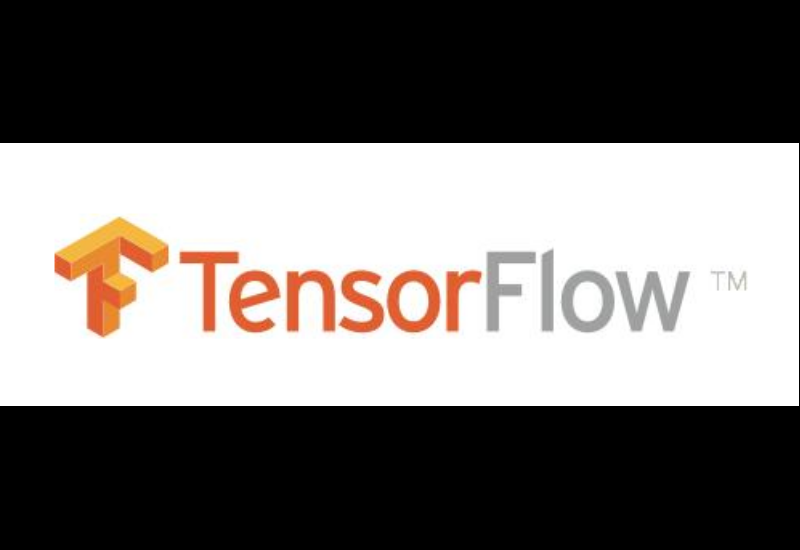

In [7]:
img_normed = prep([bim, bim1]).numpy()
r, g, b = img_normed[1]
r = r * 0.229 + 0.485
g = g * 0.224 + 0.456
b = b * 0.225 + 0.406

Image.fromarray(np.transpose((np.stack([r, g, b]) * 255).astype('uint8'), (1, 2, 0)))

In [6]:
tf.saved_model.save(prep, f'./example/preprocess_{h}x{w}/1/model.saved_model/')

INFO:tensorflow:Assets written to: ./example/preprocess_550x800/1/model.saved_model/assets
